In [1]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model 
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Dropout, add
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import numpy as np
import os
import string
import pandas as pd
import pickle
import re
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction


2025-07-21 12:33:02.390784: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753101182.415473   98364 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753101182.422950   98364 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Extracting Image Features

### Loading the VGG16 CNN

In [2]:
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)  # Remove Softmax Layer
model.summary()

I0000 00:00:1753101186.342957   98364 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

In [3]:
features={}
img_dir ='/kaggle/input/flickr8k/Images'

for img_name in os.listdir(img_dir):
    img_path = img_dir + '/' + img_name
    image = load_img(img_path,target_size=(224,224))
    image = img_to_array(image) #Converting image to a numpy array
    image = image.reshape((1,image.shape[0],image.shape[1],image.shape[2]))
    image = preprocess_input(image)
    feature = model.predict(image,verbose=0) #getting the features from the images
    image_id = img_name.split('.')[0] # Removing extension
    features[image_id] = feature # Mapping each image to its extracted features

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
I0000 00:00:1753101189.834029   98412 service.cc:148] XLA service 0x7d99fc0095b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753101189.834084   98412 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1753101189.915120   98412 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1753101191.132073   98412 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


### Saving Features for future use without running the model again

In [4]:
pickle.dump(features, open(os.path.join('/kaggle/working/','features.pkl'),'wb'))

# Caption Data

### Loading Data

In [5]:
with open('/kaggle/input/flickr8k/captions.txt','r') as f:
    next(f) # because the first line has column headers which are not needed here
    captions_doc = f.read()

### Mappping each image to its caption

In [6]:
mapping = {}

for line in captions_doc.split('\n'):
    tokens = line.split(',') # Seperating images name and caption
    if len(line)<2:
        continue
    image_id, caption = tokens[0] , tokens[1:]

    image_id = image_id.split('.')[0] # Removing extension
    caption = " ".join(caption)
    
    if image_id not in mapping:
        mapping[image_id] = []  # Handling multiple captions
        
    mapping[image_id].append(caption)

In [7]:
len(mapping)

8091

### Preprocessing Captions Data

In [8]:
def clean(caption_mapping):
    for key, captions in caption_mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
            caption = re.sub(r'[^a-z\s]', '', caption)
            caption = re.sub(r'\s+', ' ', caption).strip()  
            caption = f"startseq {caption} endseq" 
            captions[i] = caption

In [9]:
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [10]:
clean(mapping)

#### Captions after cleaning

In [11]:
mapping['1000268201_693b08cb0e']

['startseq a child in a pink dress is climbing up a set of stairs in an entry way endseq',
 'startseq a girl going into a wooden building endseq',
 'startseq a little girl climbing into a wooden playhouse endseq',
 'startseq a little girl climbing the stairs to her playhouse endseq',
 'startseq a little girl in a pink dress going into a wooden cabin endseq']

In [12]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [13]:
len(all_captions)

40455

### Tokenizing captions

In [14]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [15]:
max_length = max(len(c.split()) for c in all_captions)

# Preparing Data for model training

### Making 2 splits of the data

In [16]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [22]:
train_features = {k: features[k] for k in train}
test_features = {k: features[k] for k in test}

### Data generator for passing data one by one

In [23]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], 	num_classes=vocab_size)[0]
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                X1, X2, y = list(), list(), list()
                n = 0

### Neural Network structure

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text (InputLayer)   │ (None, 37)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image (InputLayer)  │ (None, 4096)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 37, 256)   │  2,247,936 │ text[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 4096)      │          0 │ image[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 37, 256)   │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 37)        │          0 │ text[0][0]        │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │  1,048,832 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 256)       │    525,312 │ dropout_3[0][0],  │
│                     │                   │            │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 256)       │          0 │ dense_3[0][0],    │
│                     │                   │            │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │     65,792 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 8781)      │  2,256,717 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,144,589 (23.44 MB)

 Trainable params: 6,144,589 (23.44 MB)

 Non-trainable params: 0 (0.00 B)

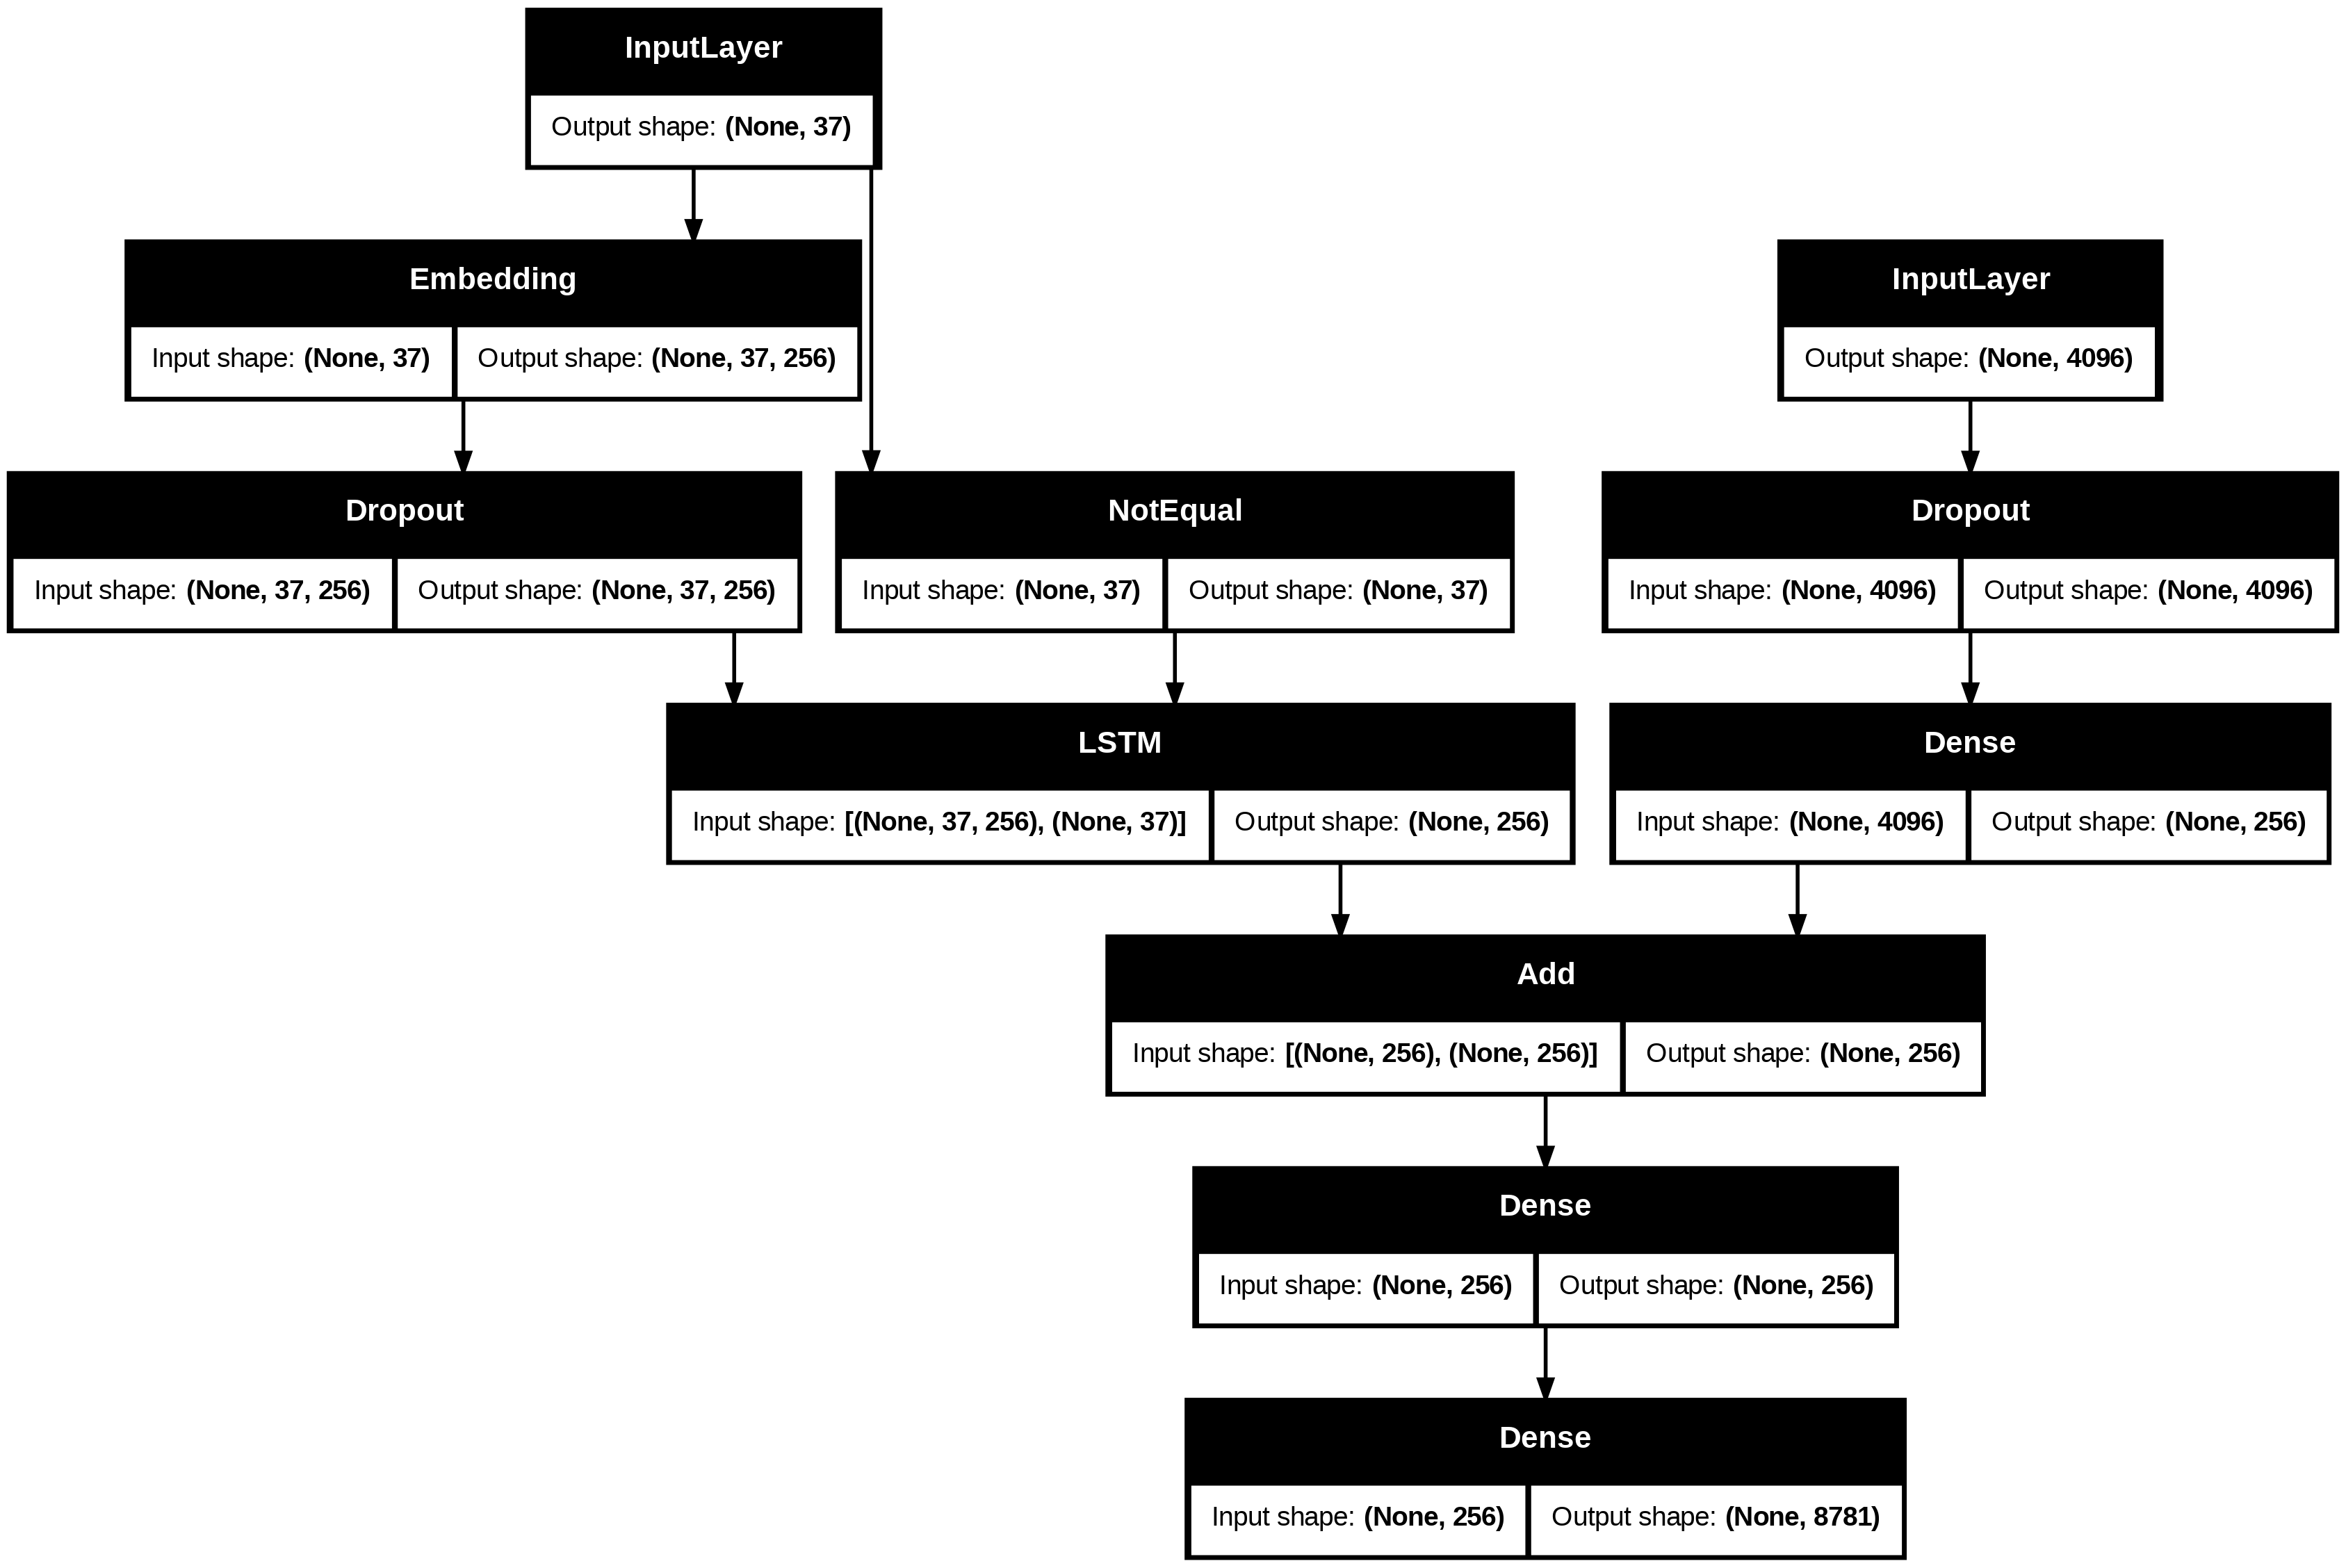

In [25]:
# Image model
inputs1 = Input(shape=(4096,), name="image")
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# Caption model
inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256, use_cudnn=False)(se2)

# Decoder
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

plot_model(model, show_shapes=True)

# Model Training

In [26]:
batch_size = 64
train_steps = len(train) // batch_size
val_steps = len(test) // batch_size

train_generator = data_generator(train, mapping, train_features, tokenizer, max_length, vocab_size, batch_size)
val_generator   = data_generator(test, mapping, test_features, tokenizer, max_length, vocab_size, batch_size)

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = model.fit(
    train_generator,
    epochs=10,
    steps_per_epoch=train_steps,
    validation_data=val_generator,
    validation_steps=val_steps,
    callbacks=[early_stopping]
)

Epoch 1/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 326s 3s/step - loss: 5.8351 - val_loss: 4.3476
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 236s 2s/step - loss: 4.0501 - val_loss: 3.5949
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 213s 2s/step - loss: 3.4060 - val_loss: 3.4244
Epoch 4/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - loss: 3.1279 - val_loss: 3.3738
Epoch 5/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - loss: 2.9309 - val_loss: 3.3678
Epoch 6/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 88s 779ms/step - loss: 2.7906 - val_loss: 3.3628
Epoch 7/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 97s 867ms/step - loss: 2.6770 - val_loss: 3.4077
Epoch 8/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 86s 767ms/step - loss: 2.5918 - val_loss: 3.4326


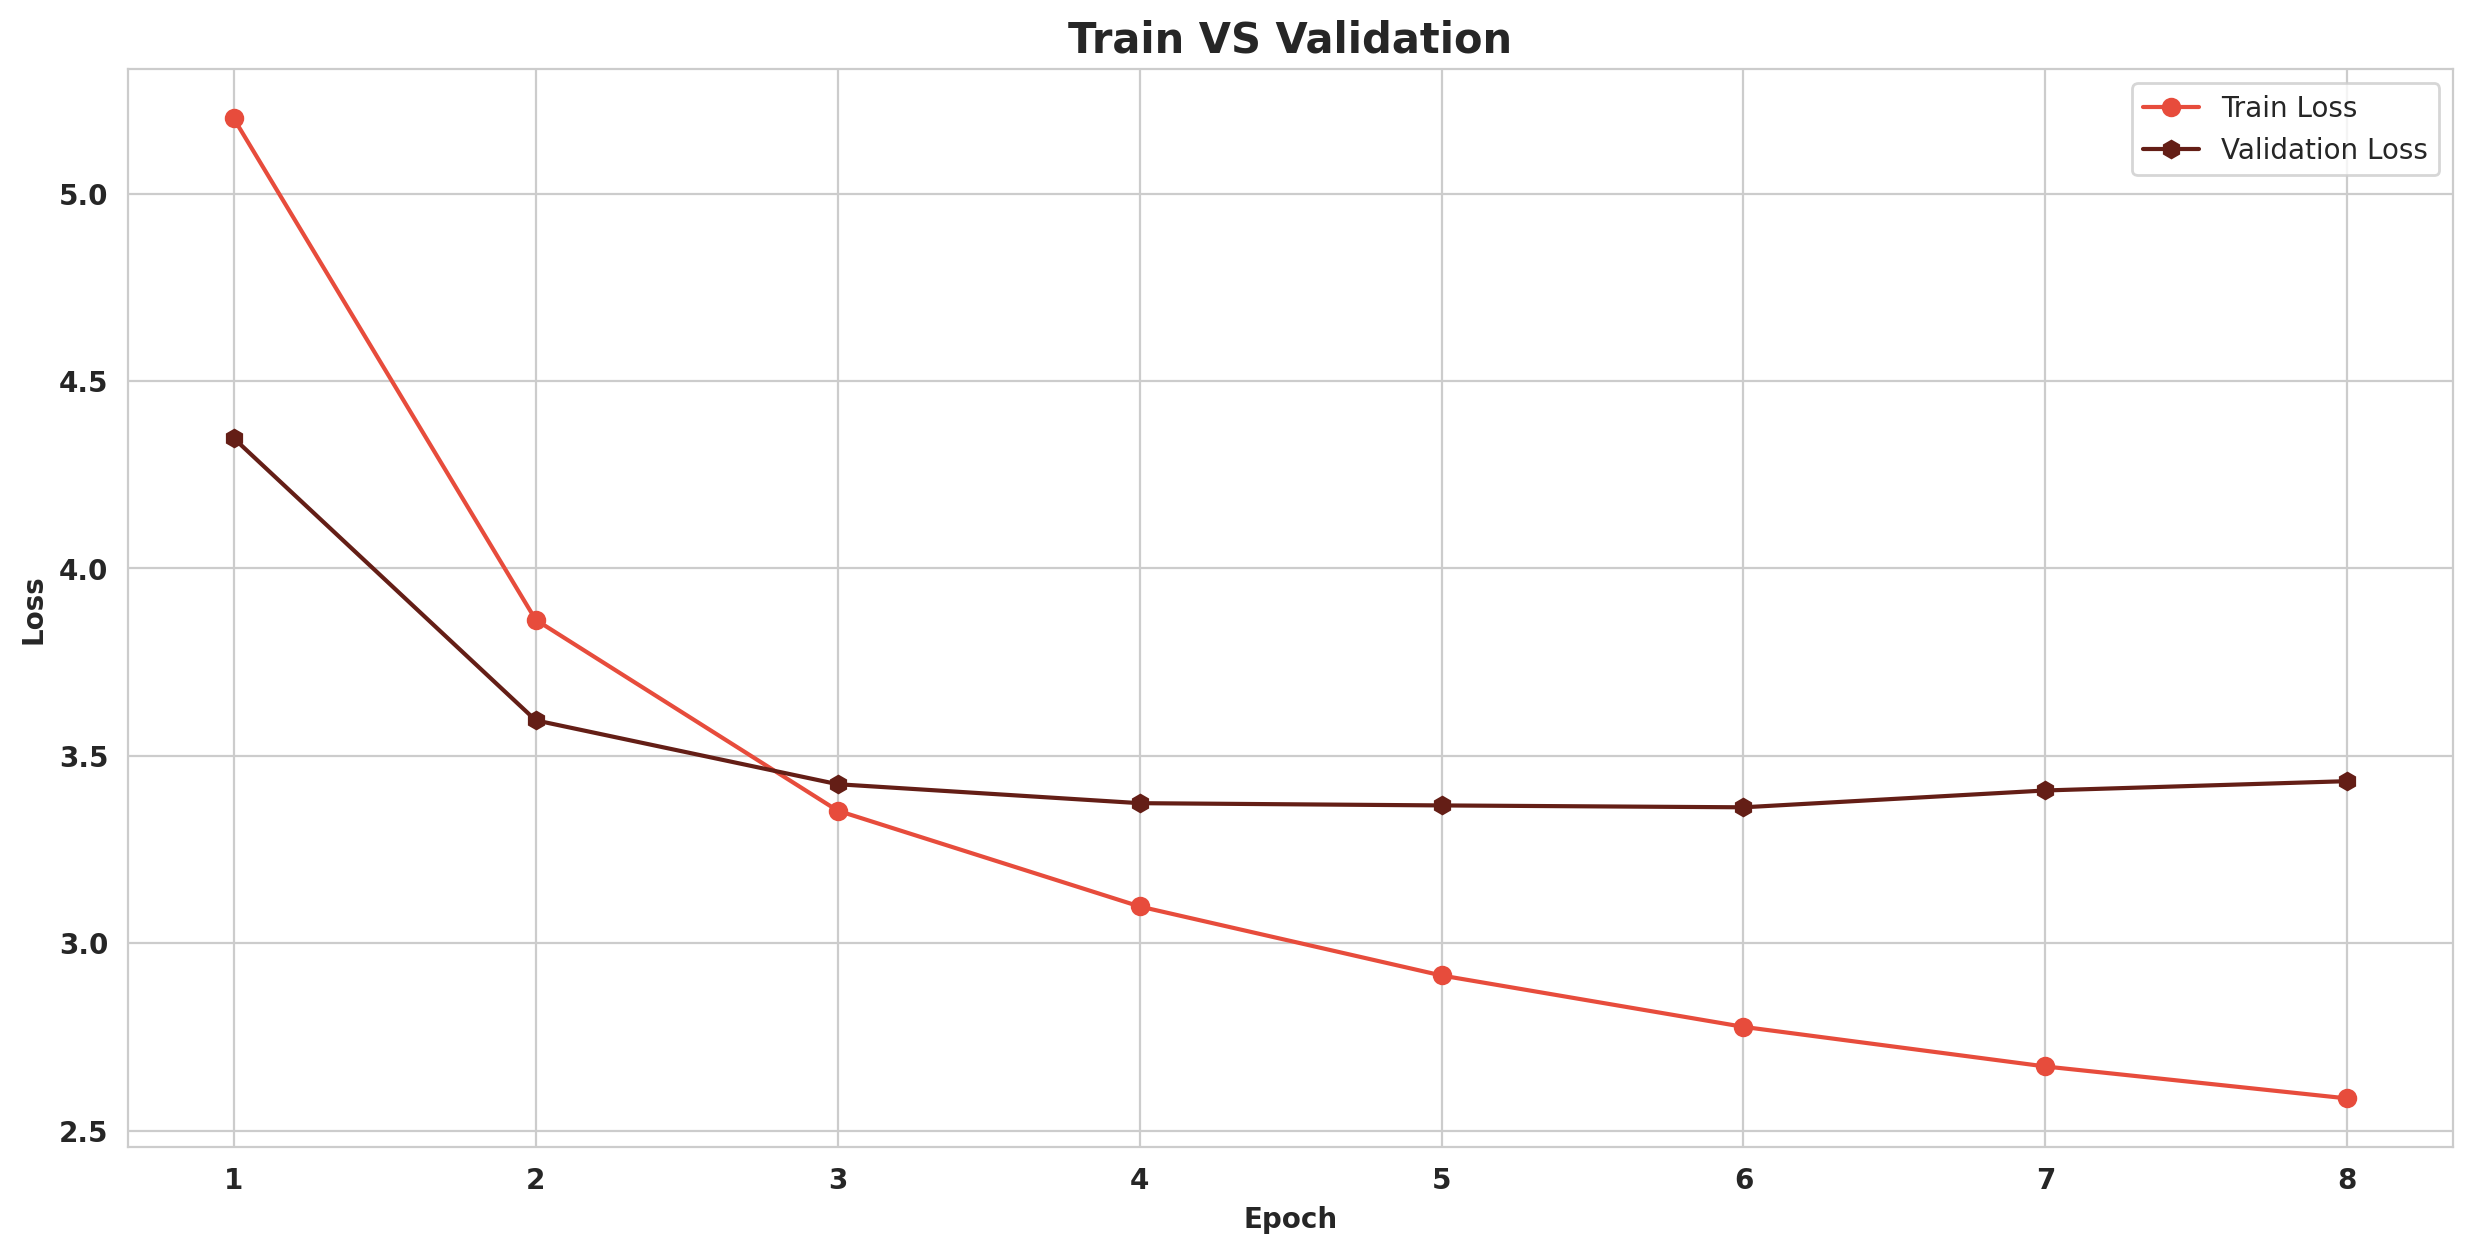

In [27]:
plt.figure(figsize=(15, 7), dpi=200)
sns.set_style('whitegrid')
plt.plot([x+1 for x in range(len(history.history['loss']))], history.history['loss'], color='#E74C3C', marker='o')
plt.plot([x+1 for x in range(len(history.history['loss']))], history.history['val_loss'], color='#641E16', marker='h')
plt.title('Train VS Validation', fontsize=15, fontweight='bold')
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.xlabel('Epoch', fontweight='bold')
plt.ylabel('Loss', fontweight='bold')
plt.legend(['Train Loss', 'Validation Loss'], loc='best')
plt.show()

### Model Evaluation

In [28]:
def evaluate_model(model, captions_mapping, features, tokenizer, max_length):
    actual, predicted = list(), list()
    smooth = SmoothingFunction().method4  # Improves BLEU for short sentences

    for img_id, captions in captions_mapping.items():
        y_pred = generate_caption(model, tokenizer, features[img_id].reshape((1, 4096)), max_length)
        references = [c.split() for c in captions]  # ground truth
        y_pred = y_pred.split()  # model prediction
        if len(y_pred) == 0:
            continue
        actual.append(references)
        predicted.append(y_pred)

    # Compute BLEU scores
    bleu1 = np.mean([sentence_bleu(a, p, weights=(1.0, 0, 0, 0), smoothing_function=smooth) for a, p in zip(actual, predicted)])
    bleu2 = np.mean([sentence_bleu(a, p, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth) for a, p in zip(actual, predicted)])
    bleu3 = np.mean([sentence_bleu(a, p, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smooth) for a, p in zip(actual, predicted)])
    bleu4 = np.mean([sentence_bleu(a, p, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth) for a, p in zip(actual, predicted)])

    print(f"BLEU-1: {bleu1:.4f}")
    print(f"BLEU-2: {bleu2:.4f}")
    print(f"BLEU-3: {bleu3:.4f}")
    print(f"BLEU-4: {bleu4:.4f}")


In [ ]:
test_mapping = {k: mapping[k] for k in test if k in test_features}
evaluate_model(model, test_mapping, test_features, tokenizer, max_length)

### Inference system

In [29]:
def generate_caption(model, tokenizer, photo, max_length):
    in_text = 'startseq'
    
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo, sequence], verbose=0)
        
        yhat = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat)
        
        if word is None:
            break
        
        in_text += ' ' + word
        if word == 'endseq':
            break
    
    final_caption = in_text.replace('startseq', '').replace('endseq', '').strip()
    return final_caption


In [30]:
def show_image_and_captions(image_id, image_dir, model, tokenizer, features, captions_mapping, max_length):
    # Load and display the image
    image_path = os.path.join(image_dir, image_id + '.jpg')
    image = Image.open(image_path)

    # Generate caption using the model
    feature = features[image_id].reshape((1, 4096))
    predicted_caption = generate_caption(model, tokenizer, feature, max_length)

    # Get the actual (reference) captions
    actual_captions = captions_mapping.get(image_id, [])
    actual_captions_clean = [cap.replace('startseq', '').replace('endseq', '').strip() for cap in actual_captions]

    # Plot
    plt.imshow(image)
    plt.axis('off')
    plt.title("Predicted: " + predicted_caption, fontsize=10)
    plt.show()

    # Print actual captions
    print(" Actual Captions:")
    for i, caption in enumerate(actual_captions_clean, 1):
        print(f"{i}. {caption}")

    # Print predicted caption
    print("\n Predicted Caption:")
    print(predicted_caption)


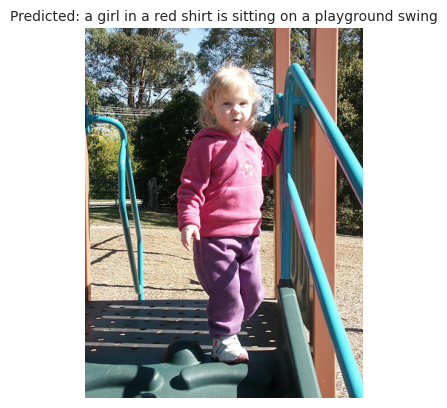

 Actual Captions:
1. a female toddler wearing a pink shirt is playing on a playground
2. a little girl in pink and purple stands on a playground
3. a very young girl is walking on a playground
4. the little girl is playing at the playground
5. young child in pink top and purple pants clutching a turquoise guard rail

 Predicted Caption:
a girl in a red shirt is sitting on a playground swing


In [39]:
sample_id = test[50]
show_image_and_captions(sample_id, img_dir, model, tokenizer, test_features, mapping, max_length)